### Daily Market Snapshot Analysis

This notebook visualizes the distribution and bifurcation of key market indicators for a **single specific date**.

**Workflow:**
1.  **Prerequisites:** The final merged data file (`{DATE_STR}_df_finviz_merged_stocks_etfs.parquet`) for the target date must exist.
2.  **Load Data:** Loads the daily snapshot data.
3.  **Generate Plots:** Creates a dashboard of histograms and scatter plots to analyze market breadth, risk, and performance distribution for that day.


### Setup and Configuration

This cell defines all necessary imports, file paths (from `config.py`), and visualization parameters.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
from typing import Tuple

# --- Project Path Setup ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

# --- Dynamic Configuration (from config.py) ---
from config import DATE_STR, DEST_DIR

# --- File Path Construction ---
DATA_DIR = Path(DEST_DIR)
SNAPSHOT_PATH = DATA_DIR / f'{DATE_STR}_df_finviz_merged_stocks_etfs.parquet'

# --- Visualization Configuration ---
# Quantiles for clipping axis limits to handle extreme outliers.
# This will show the central 99% of the data.
LOWER_QUANTILE = 0.005
UPPER_QUANTILE = 0.995

# Font sizes
SCALE_FONTSIZE = 1.2
TITLE_FONTSIZE = 16 * SCALE_FONTSIZE
AXIS_LABEL_FONTSIZE = 13 * SCALE_FONTSIZE
TICK_LABEL_FONTSIZE = 11 * SCALE_FONTSIZE
LEGEND_FONTSIZE = 11 * SCALE_FONTSIZE
SUPTITLE_FONTSIZE = 20 * SCALE_FONTSIZE

# --- Verification ---
print(f"Analyzing snapshot for date: {DATE_STR}")
print(f"Reading data from: {SNAPSHOT_PATH}")
print(f"Axis limits will be clipped to the range: ({LOWER_QUANTILE * 100:.1f}%, {UPPER_QUANTILE * 100:.1f}%)")

Analyzing snapshot for date: 2025-06-13
Reading data from: ..\data\2025-06-13_df_finviz_merged_stocks_etfs.parquet
Axis limits will be clipped to the range: (0.5%, 99.5%)


### Step 1: Load and Prepare Daily Snapshot Data

Load the merged Finviz data for the target date and perform initial cleaning.

In [52]:
print(f"--- Step 1: Loading daily snapshot data ---")

try:
    df_snapshot = pd.read_parquet(SNAPSHOT_PATH)
    # Recommended cleaning: replace infinite values with NaN for plotting
    df_snapshot.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Successfully loaded data with {df_snapshot.shape[0]} tickers.")
except FileNotFoundError:
    print(f"ERROR: Snapshot file not found at '{SNAPSHOT_PATH}'. Halting execution.")
    df_snapshot = None
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    df_snapshot = None

--- Step 1: Loading daily snapshot data ---
Successfully loaded data with 1530 tickers.


### Step 2: Define Plotting Functions

To keep the main plotting logic clean, each subplot type is generated by its own dedicated function. These functions are now enhanced to accept optional axis limits.

In [53]:
def get_quantile_limits(series: pd.Series, lower_q: float, upper_q: float) -> Tuple[float, float]:
    """Calculates the lower and upper quantile limits for a pandas Series."""
    series_cleaned = series.dropna()
    lower_bound = series_cleaned.quantile(lower_q)
    upper_bound = series_cleaned.quantile(upper_q)
    return lower_bound, upper_bound

# The function now correctly accepts arbitrary keyword arguments (**kwargs)
def plot_histogram_with_stats(ax, df, column, bins=50, title="", xlim=None, **kwargs):
    """Plots a histogram, passing any extra keyword arguments to sns.histplot."""
    # The **kwargs will unpack arguments like edgecolor, linewidth, etc.
    sns.histplot(data=df, x=column, kde=True, ax=ax, bins=bins, **kwargs)
    median_val = df[column].median()
    mean_val = df[column].mean()
    ax.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
    ax.axvline(mean_val, color='orange', linestyle=':', label=f'Mean: {mean_val:.2f}')
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xlabel(column, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Frequency', fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    ax.legend(fontsize=LEGEND_FONTSIZE)
    if xlim:
        ax.set_xlim(xlim)

def plot_scatter(ax, df, x_col, y_col, title="", xlim=None, ylim=None):
    """Plots a scatter plot with zero lines and optional axis limits."""
    sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, alpha=0.5, s=25)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.set_xlabel(x_col, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(y_col, fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    ax.axvline(0, color='grey', linestyle='--')
    ax.axhline(0, color='grey', linestyle='--')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

print("Plotting functions have been defined/updated.")

Plotting functions have been defined/updated.


### Step 3: Generate and Display Dashboard

This step creates the figure and axes, then calls the plotting functions to populate the dashboard, applying axis limits where necessary.


--- Step 3: Generating daily snapshot dashboard ---
Applying y-axis limits for 'Perf Year %' plots: (-49.2481, 304.5510500000008)
Applying axis limits for 'Quarterly Perf' plot: x=(-15.178749999999999, 37.18605000000002), y=(-24.0613, 67.3068)


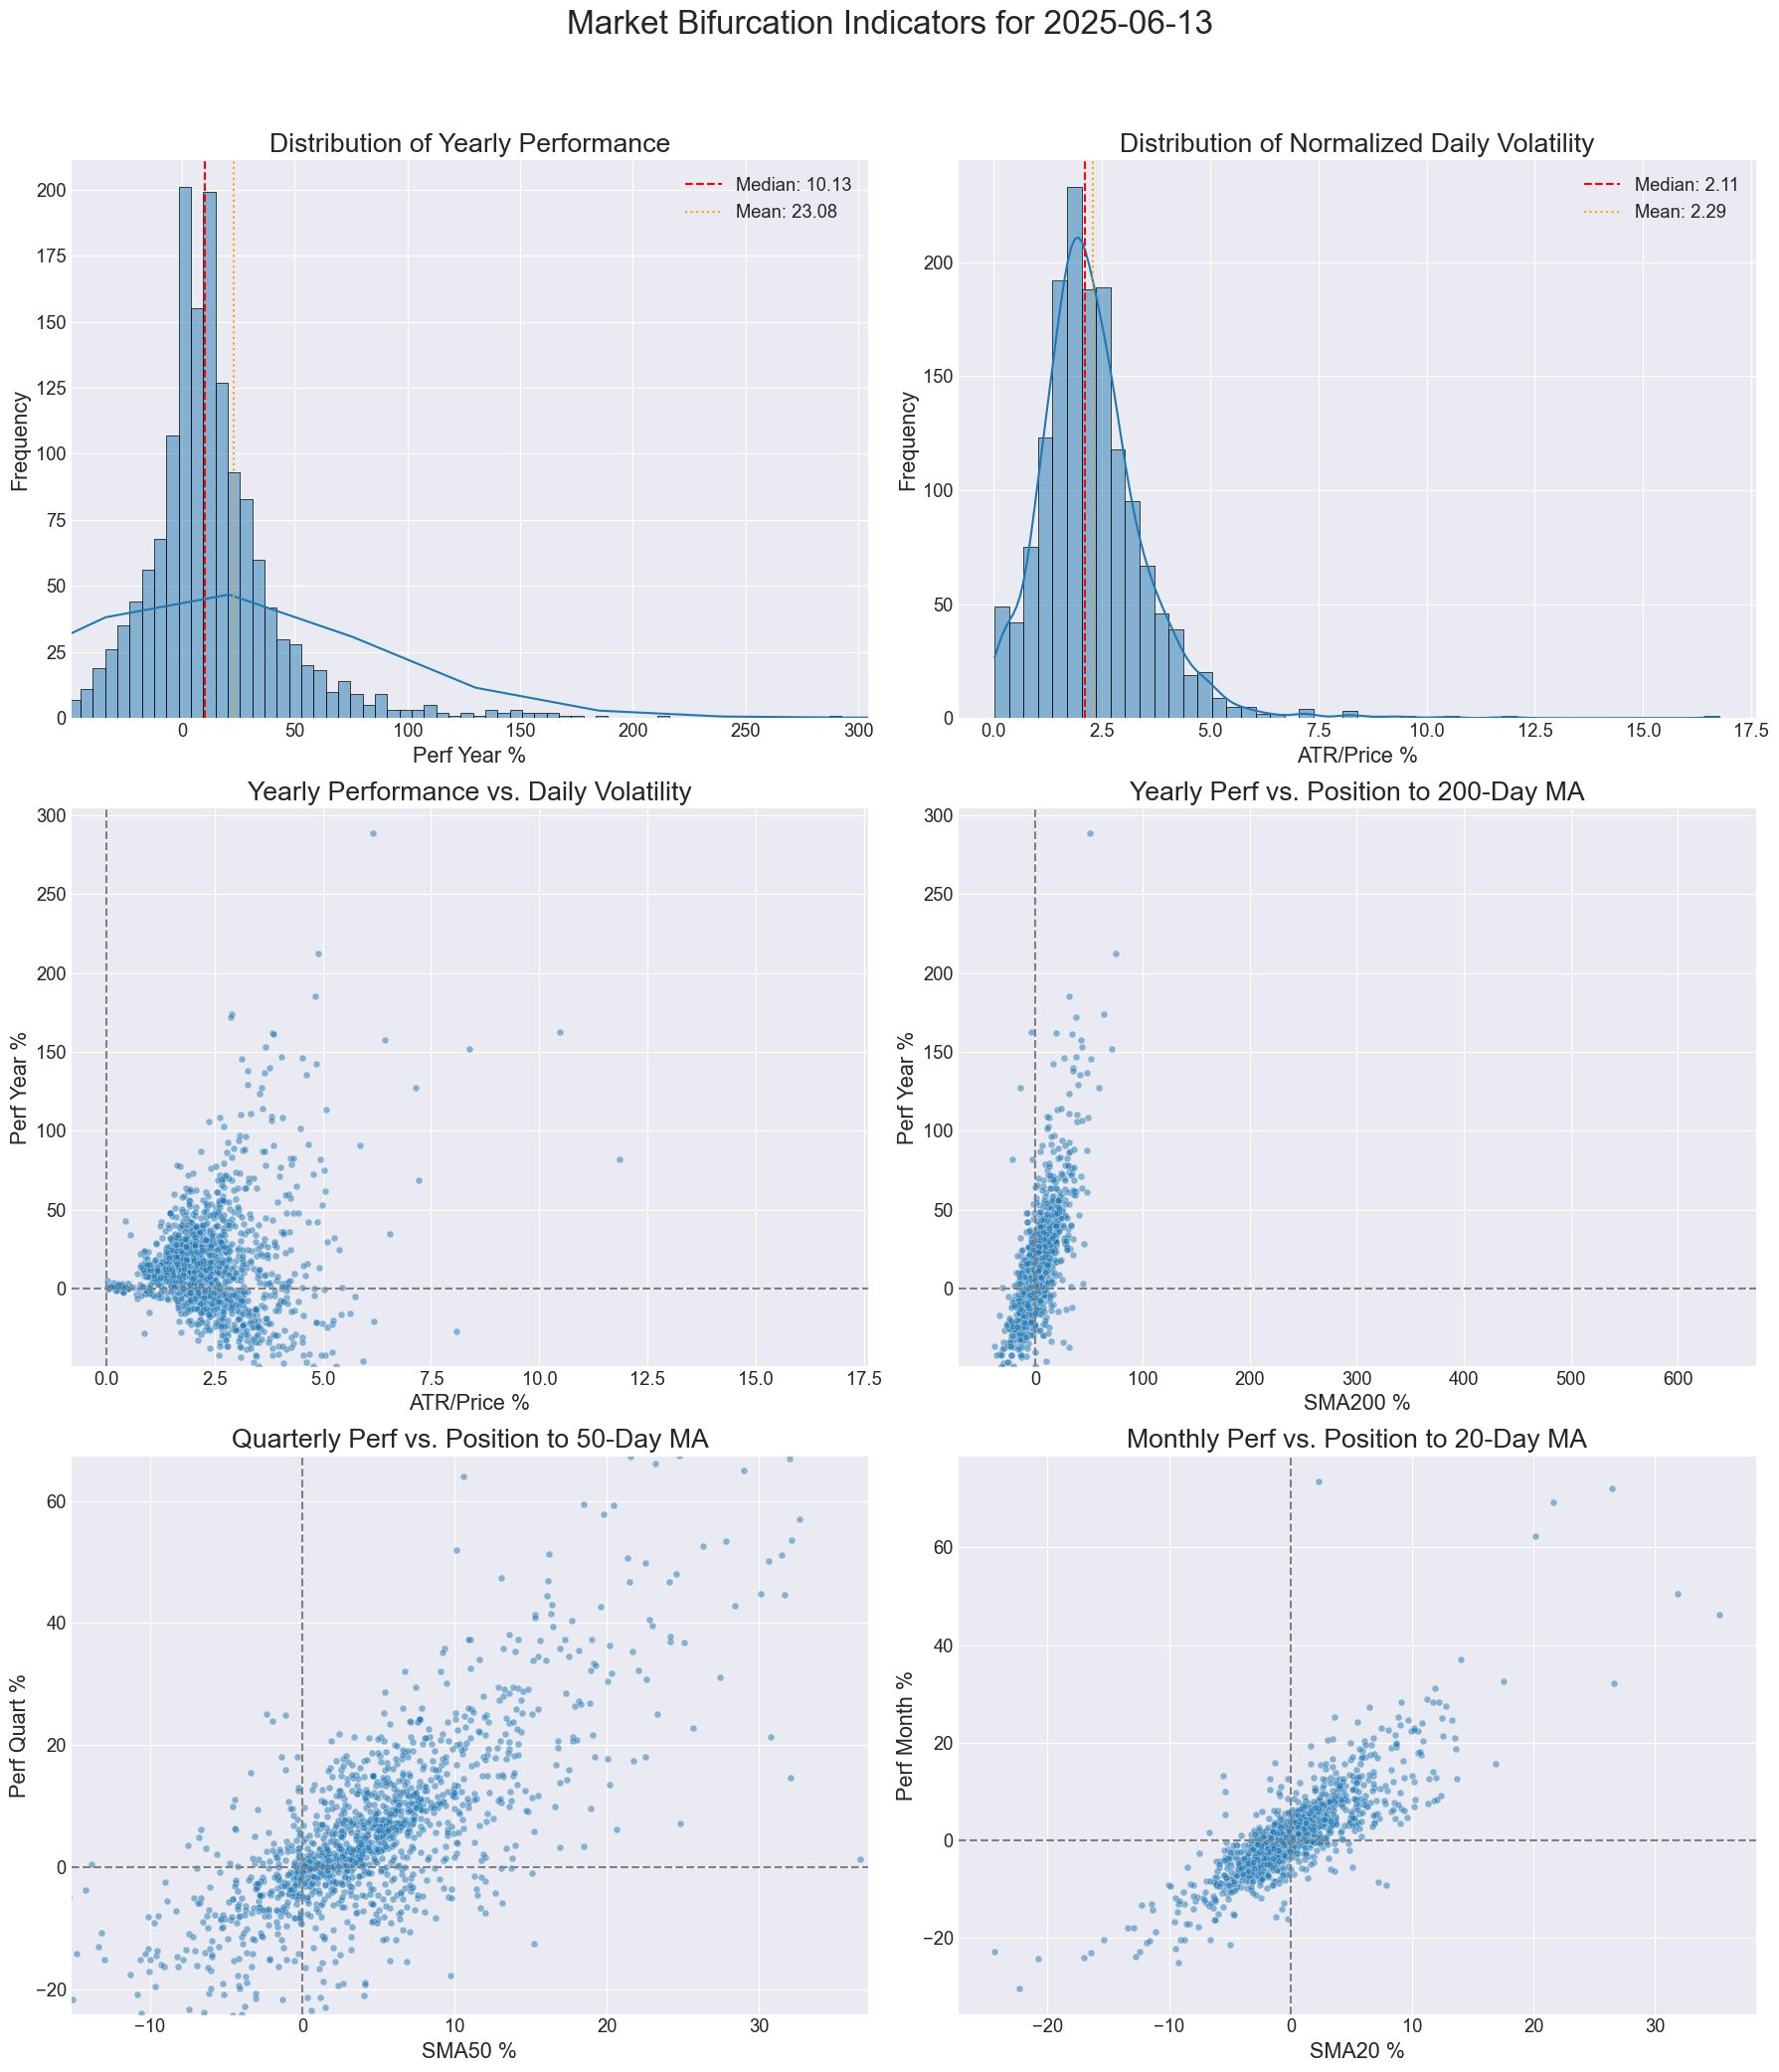

In [54]:
if df_snapshot is not None:
    print("\n--- Step 3: Generating daily snapshot dashboard ---")
    
    required_cols = ['Perf Year %', 'ATR/Price %', 'SMA200 %', 'SMA50 %', 'Perf Quart %', 'SMA20 %', 'Perf Month %']
    if not all(col in df_snapshot.columns for col in required_cols):
        print(f"ERROR: Not all required columns found. Missing: {[c for c in required_cols if c not in df_snapshot.columns]}")
    else:
        # Calculate axis limits
        y_limits_perf_year = get_quantile_limits(df_snapshot['Perf Year %'], LOWER_QUANTILE, UPPER_QUANTILE)
        x_limits_qtr = get_quantile_limits(df_snapshot['SMA50 %'], LOWER_QUANTILE, UPPER_QUANTILE)
        y_limits_qtr = get_quantile_limits(df_snapshot['Perf Quart %'], LOWER_QUANTILE, UPPER_QUANTILE)
        print(f"Applying y-axis limits for 'Perf Year %' plots: {y_limits_perf_year}")
        print(f"Applying axis limits for 'Quarterly Perf' plot: x={x_limits_qtr}, y={y_limits_qtr}")

        plt.style.use('seaborn-v0_8-darkgrid')
        fig, axes = plt.subplots(3, 2, figsize=(18, 21))
        fig.suptitle(f'Market Bifurcation Indicators for {DATE_STR}', fontsize=SUPTITLE_FONTSIZE, y=1.01)
        
        # --- FIX: Pass styling arguments directly as keyword arguments ---
        # These will be captured by **kwargs in the helper function.
        plot_histogram_with_stats(axes[0, 0], df_snapshot, 'Perf Year %', 
                                  title='Distribution of Yearly Performance', 
                                  xlim=y_limits_perf_year, 
                                  bins=2000, 
                                  edgecolor='black', 
                                  linewidth=0.5)
        
        plot_histogram_with_stats(axes[0, 1], df_snapshot, 'ATR/Price %', 
                                  title='Distribution of Normalized Daily Volatility', 
                                  edgecolor='black', 
                                  linewidth=0.5)
        
        plot_scatter(axes[1, 0], df_snapshot, x_col='ATR/Price %', y_col='Perf Year %', title='Yearly Performance vs. Daily Volatility', ylim=y_limits_perf_year)
        plot_scatter(axes[1, 1], df_snapshot, x_col='SMA200 %', y_col='Perf Year %', title='Yearly Perf vs. Position to 200-Day MA', ylim=y_limits_perf_year)
        
        plot_scatter(axes[2, 0], df_snapshot, x_col='SMA50 %', y_col='Perf Quart %', title='Quarterly Perf vs. Position to 50-Day MA', xlim=x_limits_qtr, ylim=y_limits_qtr)
        
        plot_scatter(axes[2, 1], df_snapshot, x_col='SMA20 %', y_col='Perf Month %', title='Monthly Perf vs. Position to 20-Day MA')

        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
else:
    print("\nSkipping plot generation because no data was loaded.")